### KNN Classification
Symphony approach: Calculates the weighted Mahalanobis distance for the query cells to reference clusters. Returns a vector of distance scores, one per query cell. Higher distance metric indicates less confidence - The actual per-cell score is the average of the distances weighted by the clusters the cell belongs to

In [1]:
import os
os.chdir('../') 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import anndata as ad
import pandas as pd

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/home/alextopalova/miniconda3/envs/archmap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:
from uncert_metric import *

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(3, 3))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

# Pancreas

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'
source_adata = sc.read("source/source__pancreas.h5ad")
target_adata = sc.read("target/target__pancreas.h5ad")
surgery_path = "surgery_model/surgery_model_pancreas"

In [6]:
model = sca.models.TRVAE.load(surgery_path, source_adata)

AnnData object with n_obs × n_vars = 10294 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [7]:
adata_ref_latent = sc.AnnData(model.get_latent(source_adata.X, source_adata.obs[condition_key]))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

In [8]:
adata_query_latent = sc.AnnData(model.get_latent(target_adata.X, target_adata.obs[condition_key]))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [9]:
uncertainties,centroids = classification_uncert_mahalanobis(
    adata_ref_latent = adata_ref_latent, 
    adata_query_latent = adata_query_latent,
    cell_type_key = "cell_type"
)

[[1.64e-16 3.84e-05 1.88e-08 1.23e-05 1.33e-01 8.98e-07 7.81e-17 8.67e-01]
 [9.37e-01 6.31e-02 9.93e-22 4.08e-06 2.11e-09 1.36e-06 8.62e-15 1.02e-07]
 [4.82e-07 2.27e-06 1.55e-15 1.23e-06 1.98e-10 1.00e+00 1.27e-13 6.94e-09]
 [4.77e-24 3.34e-15 6.99e-10 1.00e+00 6.80e-10 1.71e-11 4.68e-28 6.88e-13]
 [1.34e-04 8.06e-08 7.08e-10 1.00e+00 7.36e-11 2.42e-06 3.86e-25 7.79e-08]
 [3.13e-12 9.15e-13 8.80e-02 1.66e-07 4.77e-07 9.11e-01 7.36e-11 6.16e-04]
 [4.08e-18 8.96e-08 9.31e-11 6.47e-08 1.32e-01 2.45e-09 4.77e-16 8.68e-01]
 ...
 [2.44e-16 2.53e-14 5.04e-07 1.00e+00 2.22e-12 2.38e-11 5.09e-17 3.02e-10]
 [2.07e-32 1.96e-11 6.02e-16 2.00e-13 9.26e-01 3.10e-13 2.42e-36 7.45e-02]
 [4.01e-12 1.00e+00 2.44e-34 3.63e-11 1.74e-09 1.15e-11 1.91e-21 8.08e-12]
 [2.57e-19 7.35e-08 1.19e-16 3.53e-10 7.73e-01 2.52e-14 7.33e-21 2.27e-01]
 [1.00e+00 1.13e-06 1.20e-23 1.85e-08 9.61e-15 2.49e-08 1.97e-19 5.16e-12]
 [2.13e-34 1.42e-11 6.79e-19 2.12e-14 9.72e-01 4.35e-15 4.19e-31 2.85e-02]
 [1.65e-24 7.42e-09 

In [10]:
uncertainties

,uncertainty
0,0.178456
1,0.409365
2,0.171702
3,0.587725
4,0.32867
...,...
5382,0.598854
5383,0.356352
5384,0.338445
5385,0.434776


In [11]:
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

In [12]:
adata_query_latent

AnnData object with n_obs × n_vars = 5387 × 10
    obs: 'cell_type', 'batch'
    obsm: 'uncertainty_mahalanobis'

/home/alextopalova/miniconda3/envs/archmap/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alextopalova/miniconda3/envs/archmap/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alextopalova/miniconda3/envs/archmap/lib/python3

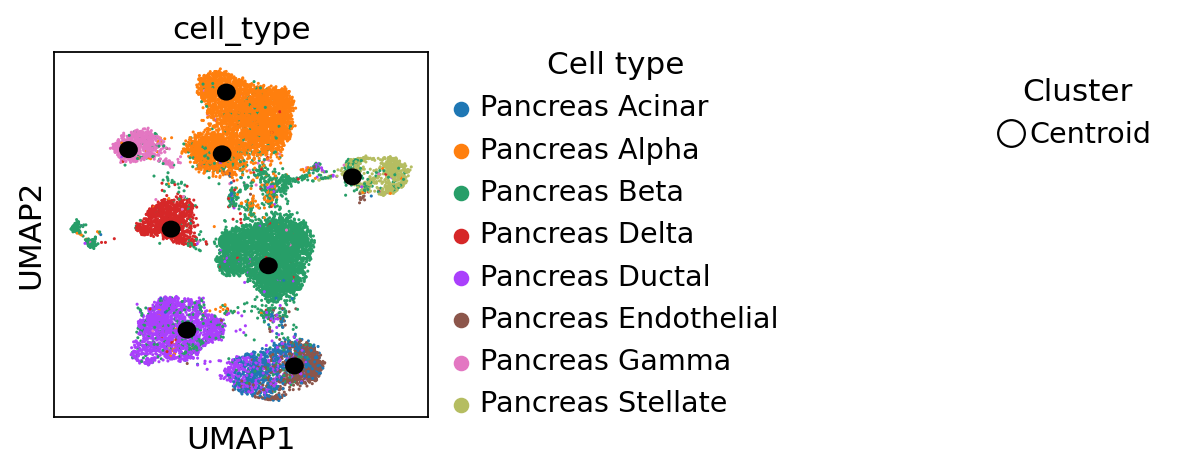

In [13]:
centroid_map(adata_ref=adata_ref_latent, adata_query=adata_query_latent, centroids = centroids, cell_type_key="cell_type")

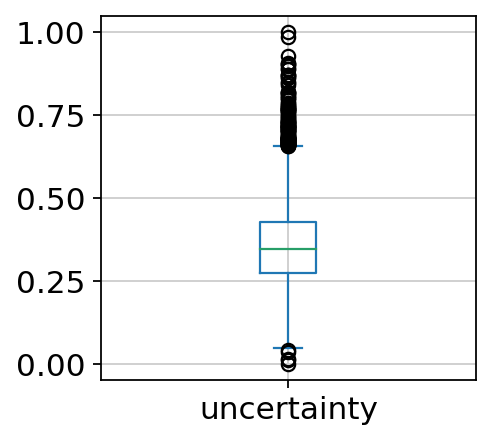

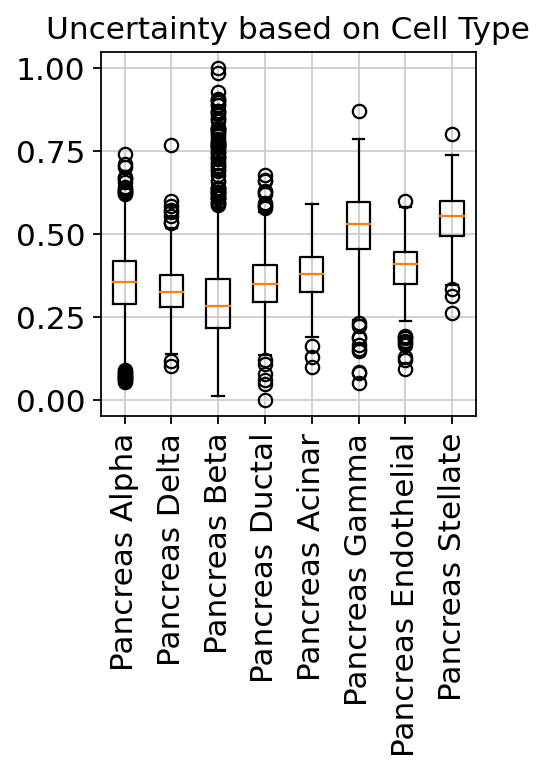

In [14]:
uncert_diagram(uncertainties, cell_type_key)

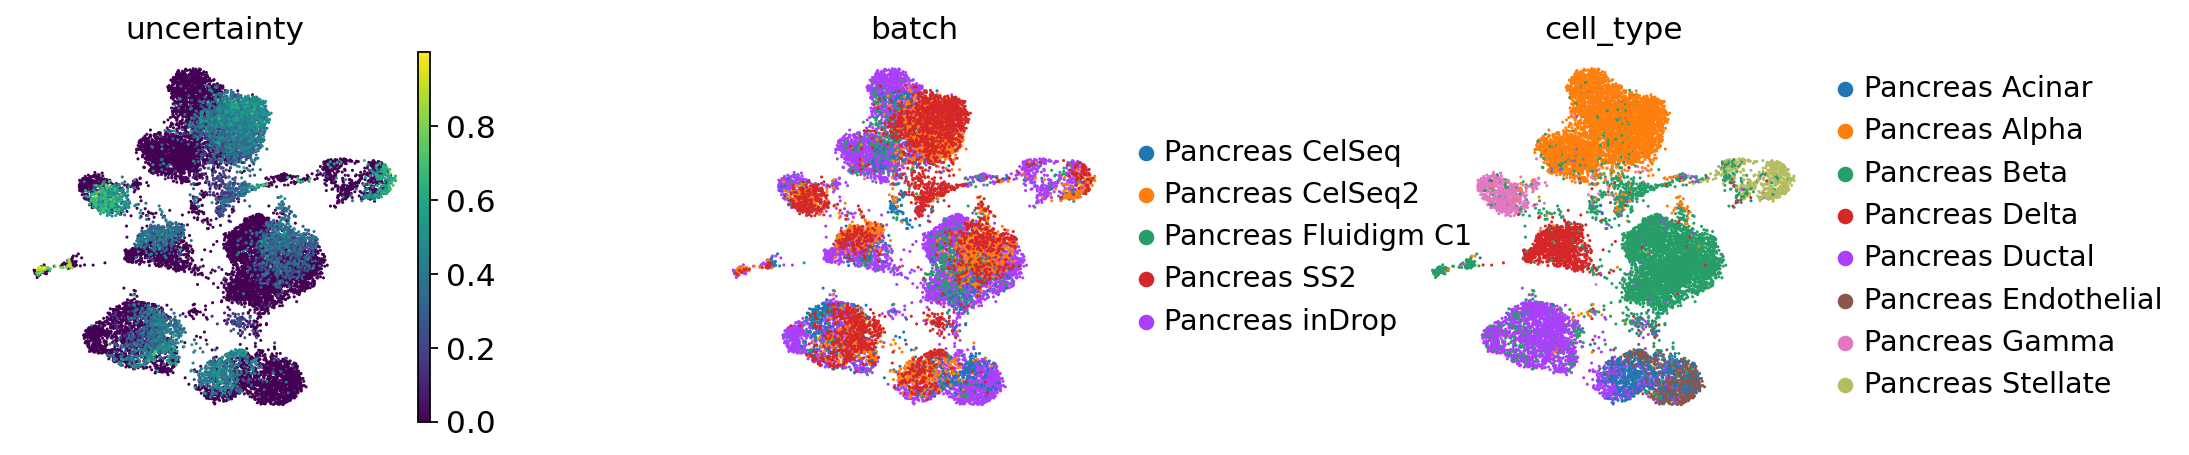

In [15]:
uncert_umap_diagram(
        adata_ref_latent,
        adata_query_latent,
        uncertainties["uncertainty"],
        batch_key = "batch",
        cell_type_key = cell_type_key)

# Pancreas no alpha

In [16]:
condition_key = 'study'
cell_type_key = 'cell_type'
source_adata = sc.read("source/source__pancreas_no_alpha.h5ad")
target_adata = sc.read("target/target__pancreas_no_alpha.h5ad")
surgery_path = "surgery_model/surgery_model_pancreas_no_alpha"

In [17]:
model = sca.models.TRVAE.load(surgery_path, source_adata)

AnnData object with n_obs × n_vars = 7584 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [18]:
adata_ref_latent = sc.AnnData(model.get_latent(source_adata.X, source_adata.obs[condition_key]))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

In [19]:
adata_query_latent = sc.AnnData(model.get_latent(target_adata.X, target_adata.obs[condition_key]))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [20]:
uncertainties,_ = classification_uncert_mahalanobis(
    adata_ref_latent = adata_ref_latent, 
    adata_query_latent = adata_query_latent,
    cell_type_key = "cell_type"
)

[[9.98e-01 7.77e-31 1.49e-03 3.31e-08 2.38e-04 6.33e-09 1.03e-15]
 [1.00e+00 8.89e-34 5.56e-05 6.61e-10 3.96e-06 2.38e-16 7.22e-25]
 [1.02e-07 4.37e-48 9.99e-01 4.08e-10 6.99e-04 3.25e-19 9.28e-29]
 [1.23e-08 2.67e-08 4.73e-06 1.00e+00 1.61e-09 3.74e-05 8.97e-38]
 [3.89e-04 5.80e-19 5.36e-06 1.00e+00 1.81e-05 1.29e-07 8.66e-26]
 [5.11e-05 2.43e-10 9.92e-01 4.00e-09 5.92e-03 1.73e-03 6.67e-21]
 [9.99e-01 6.57e-33 1.38e-03 4.58e-09 1.80e-05 1.17e-10 3.35e-21]
 ...
 [1.60e-10 2.91e-11 1.02e-07 1.00e+00 3.54e-14 4.90e-04 1.34e-14]
 [1.00e+00 4.29e-45 3.25e-04 1.25e-09 9.47e-05 1.33e-19 7.43e-34]
 [1.00e+00 7.79e-54 5.87e-07 4.75e-12 4.34e-06 3.44e-29 5.08e-24]
 [1.00e+00 3.95e-37 1.99e-04 8.09e-11 2.36e-05 4.38e-15 2.00e-27]
 [1.00e+00 3.13e-43 5.15e-05 8.01e-09 1.21e-05 6.78e-19 5.88e-24]
 [1.00e+00 7.24e-46 8.10e-05 1.43e-10 8.06e-06 4.70e-20 5.15e-24]
 [9.99e-01 4.40e-44 9.89e-04 4.29e-11 3.89e-05 4.65e-16 6.49e-24]]


In [21]:
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

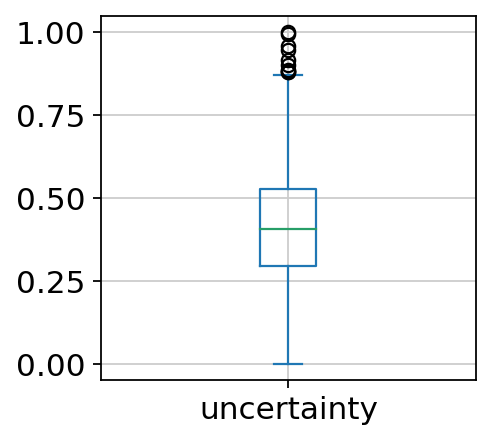

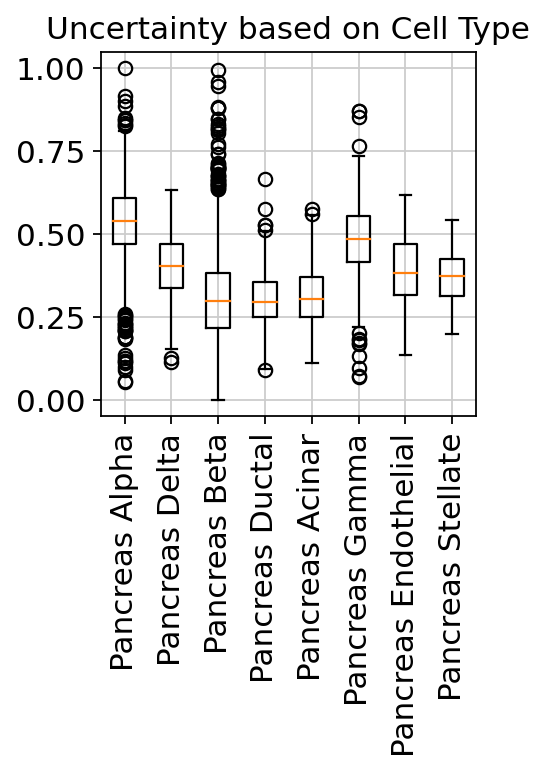

In [22]:
uncert_diagram(uncertainties, cell_type_key)

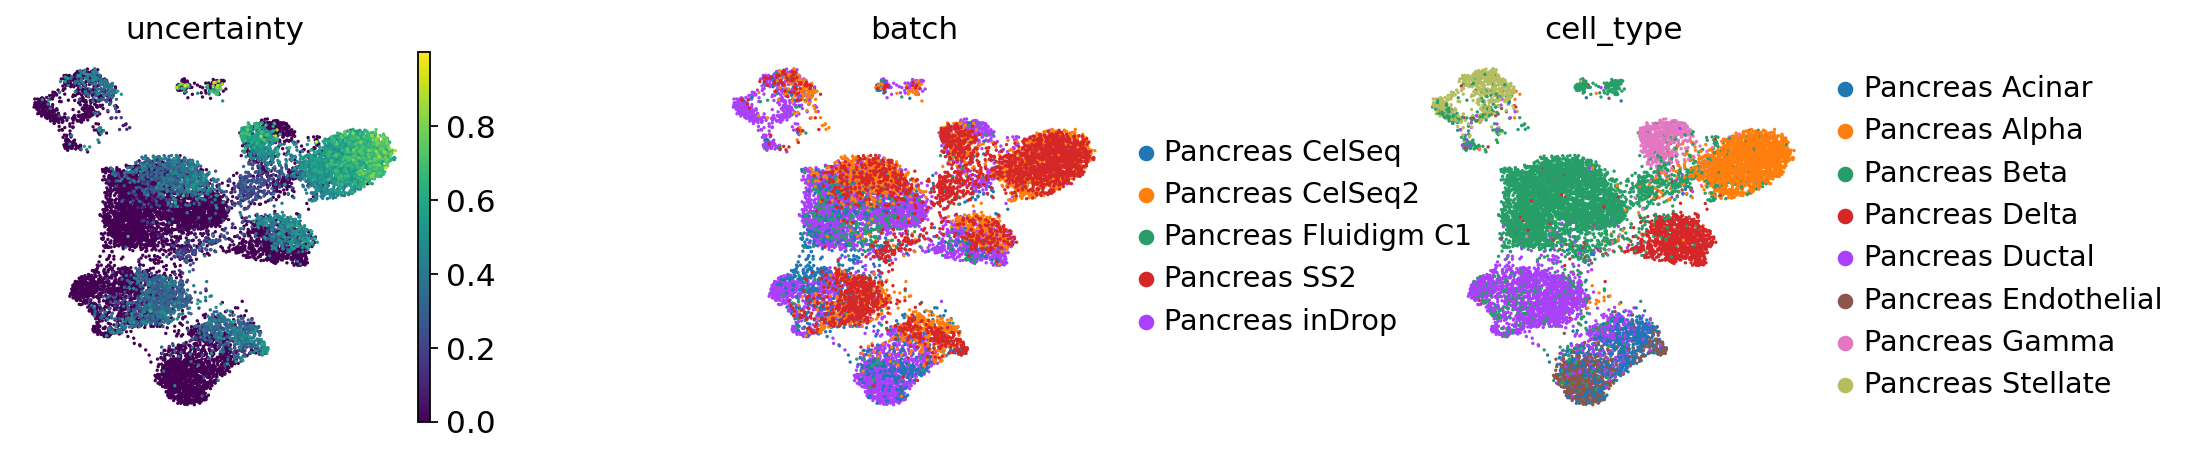

In [23]:
uncert_umap_diagram(
        adata_ref_latent,
        adata_query_latent,
        uncertainties["uncertainty"],
        batch_key = "batch",
        cell_type_key = cell_type_key)

# PBMC

In [24]:
condition_key = 'batch' 
cell_type_key = 'final_annotation'
source_adata = sc.read("source/source__pbmc.h5ad")
target_adata = sc.read("target/target__pbmc.h5ad")
surgery_path = "surgery_model/surgery_model_pbmc"

In [25]:
model = sca.models.TRVAE.load(surgery_path, source_adata)

AnnData object with n_obs × n_vars = 29195 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [26]:
adata_ref_latent = sc.AnnData(model.get_latent(source_adata.X, source_adata.obs[condition_key]))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

In [27]:
adata_query_latent = sc.AnnData(model.get_latent(target_adata.X, target_adata.obs[condition_key]))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [28]:
uncertainties,_ = classification_uncert_mahalanobis(
    adata_ref_latent = adata_ref_latent, 
    adata_query_latent = adata_query_latent,
    cell_type_key = "cell_type"
)

[[3.31e-009 2.16e-027 5.13e-027 1.12e-030 3.10e-013 1.00e+000 1.41e-043
  ... 3.10e-005 3.22e-017 6.90e-024 9.61e-024 2.38e-019 3.20e-016
  5.05e-021]
 [1.24e-027 2.53e-006 1.93e-013 6.15e-018 1.04e-013 2.16e-051 4.44e-031
  ... 4.16e-004 5.19e-001 4.80e-001 2.31e-021 1.87e-007 5.52e-006
  1.78e-017]
 [9.79e-001 1.47e-013 3.63e-043 3.00e-028 1.24e-002 2.59e-007 4.71e-036
  ... 4.01e-008 2.14e-010 5.74e-017 2.43e-019 2.25e-007 2.26e-012
  8.98e-003]
 [2.68e-001 2.51e-017 1.89e-050 5.47e-031 1.51e-003 1.29e-012 9.38e-037
  ... 1.53e-007 2.88e-012 1.68e-019 5.96e-021 5.43e-010 7.41e-017
  7.31e-001]
 [9.33e-020 1.33e-009 2.61e-047 5.82e-035 3.32e-002 8.49e-027 1.92e-021
  ... 7.29e-001 5.69e-002 1.45e-006 5.19e-003 9.67e-002 1.03e-002
  2.18e-021]
 [6.63e-001 7.29e-021 1.64e-052 6.88e-034 2.57e-003 1.63e-015 2.18e-045
  ... 4.91e-009 2.18e-012 2.96e-018 4.80e-023 5.16e-009 3.27e-016
  3.34e-001]
 [1.26e-003 2.98e-019 7.23e-043 4.20e-026 1.31e-001 1.88e-018 3.08e-046
  ... 1.17e-006 6.11e-

In [29]:
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

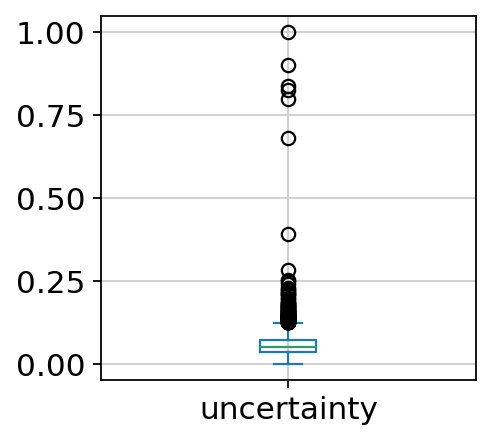

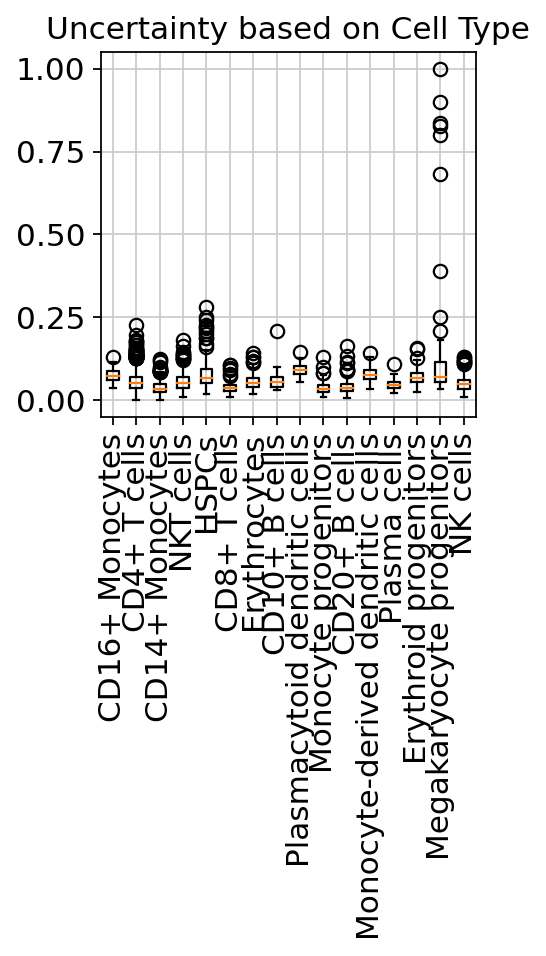

In [30]:
uncert_diagram(uncertainties, "cell_type")

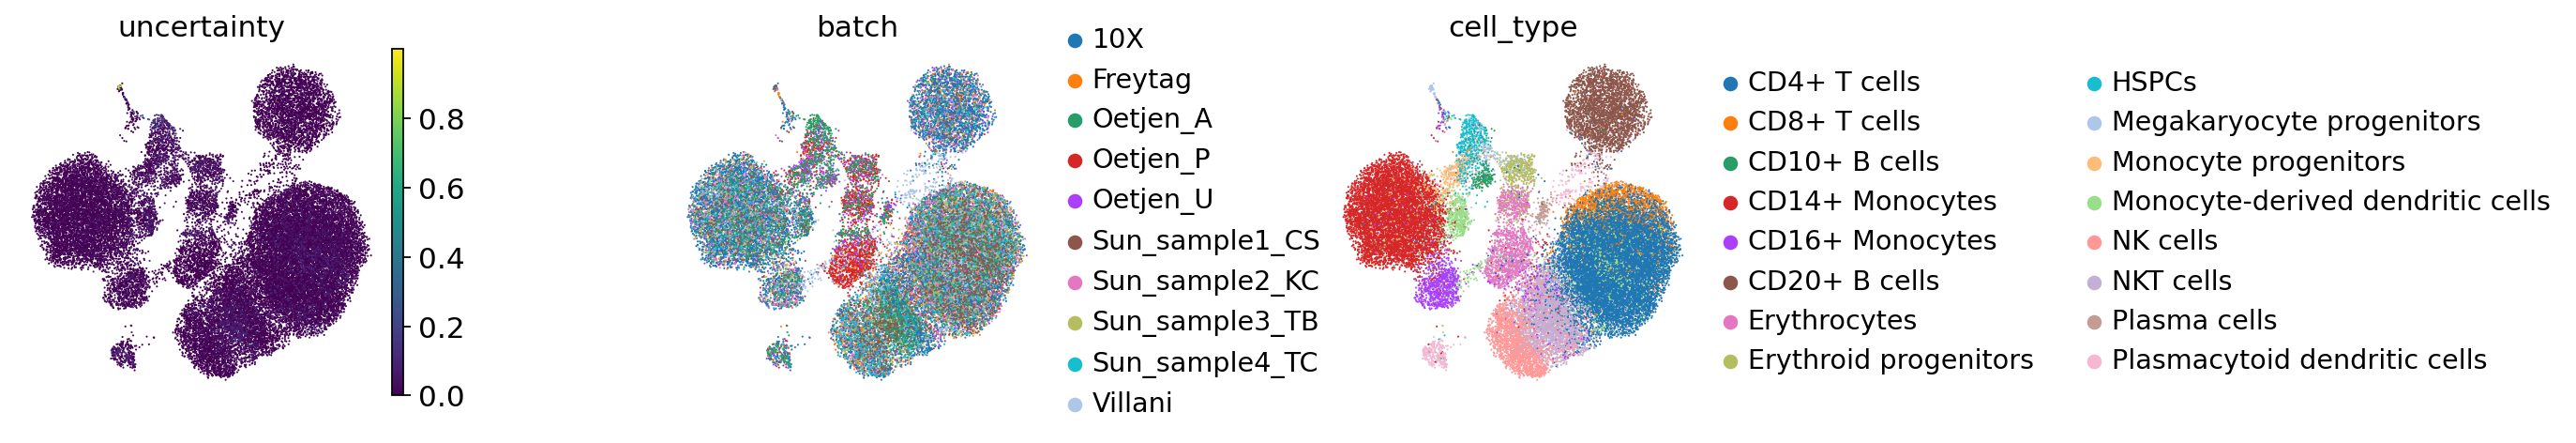

In [31]:
uncert_umap_diagram(
        adata_ref_latent,
        adata_query_latent,
        uncertainties["uncertainty"],
        batch_key = "batch",
        cell_type_key = "cell_type")

# PBMC 10X and Villani

In [32]:
condition_key = 'batch' 
cell_type_key = 'final_annotation'
source_adata = sc.read("source/source__pbmc_10x_villani.h5ad")
target_adata = sc.read("target/target__pbmc_10x_villani.h5ad")
surgery_path = "surgery_model/surgery_model_pbmc_10x_villani"

In [54]:
target_adata.obs[target_adata.obs["batch"] == "Villani"].groupby("final_annotation").count()

,batch,chemistry,data_type,dpt_pseudotime,mt_frac,n_counts,n_genes,sample_ID,size_factors,species,study,tissue
final_annotation,,,,,,,,,,,,
CD4+ T cells,0,0,0,0,0,0,0,0,0,0,0,0
CD8+ T cells,0,0,0,0,0,0,0,0,0,0,0,0
CD14+ Monocytes,145,145,145,0,0,0,145,145,0,145,145,145
CD16+ Monocytes,172,172,172,0,0,0,172,172,0,172,172,172
CD20+ B cells,0,0,0,0,0,0,0,0,0,0,0,0
HSPCs,0,0,0,0,0,0,0,0,0,0,0,0
Megakaryocyte progenitors,0,0,0,0,0,0,0,0,0,0,0,0
Monocyte-derived dendritic cells,534,534,534,0,0,0,534,534,0,534,534,534
NK cells,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
model = sca.models.TRVAE.load(surgery_path, source_adata)

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [34]:
adata_ref_latent = sc.AnnData(model.get_latent(source_adata.X, source_adata.obs[condition_key]))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

In [35]:
adata_query_latent = sc.AnnData(model.get_latent(target_adata.X, target_adata.obs[condition_key]))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [36]:
uncertainties,_ = classification_uncert_mahalanobis(
    adata_ref_latent = adata_ref_latent, 
    adata_query_latent = adata_query_latent,
    cell_type_key = "cell_type"
)

[[9.22e-21 6.29e-24 5.93e-03 3.18e-01 2.28e-25 3.32e-26 1.52e-02 ...
  1.26e-06 3.00e-16 2.42e-19 3.68e-36 3.00e-01 3.61e-01 4.89e-34]
 [5.53e-03 2.01e-09 9.20e-07 6.57e-11 3.96e-41 2.22e-12 4.65e-07 ...
  4.19e-10 9.94e-01 8.45e-37 2.34e-26 6.51e-06 1.20e-17 3.57e-06]
 [9.94e-01 1.30e-09 7.12e-07 6.01e-10 6.70e-20 3.66e-32 7.09e-10 ...
  4.99e-07 3.17e-14 1.25e-37 7.23e-33 5.87e-03 1.08e-19 3.96e-04]
 [1.59e-24 1.68e-32 2.67e-09 1.34e-04 2.55e-26 5.03e-22 5.32e-09 ...
  4.20e-10 1.95e-05 8.75e-14 8.23e-17 4.70e-03 9.95e-01 1.90e-18]
 [1.05e-13 2.02e-25 5.24e-06 5.21e-07 6.40e-14 8.14e-01 4.76e-08 ...
  2.71e-06 2.09e-14 1.25e-15 2.59e-20 1.86e-01 2.67e-07 5.27e-09]
 [1.10e-27 4.27e-38 6.25e-09 8.57e-04 1.92e-27 9.41e-25 1.71e-11 ...
  7.59e-08 4.90e-08 9.23e-13 4.97e-20 6.20e-03 9.93e-01 3.33e-23]
 [4.97e-20 2.09e-31 4.22e-02 1.80e-02 2.88e-40 6.04e-26 9.28e-01 ...
  1.96e-05 6.15e-19 5.24e-19 2.64e-29 1.09e-02 8.99e-04 3.34e-34]
 ...
 [4.00e-02 1.21e-02 9.93e-06 7.29e-08 4.96e-25 3.5

In [37]:
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

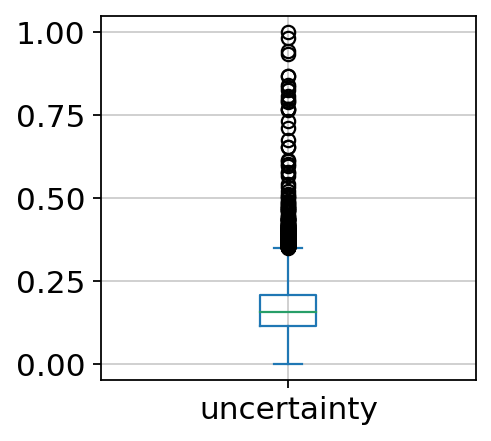

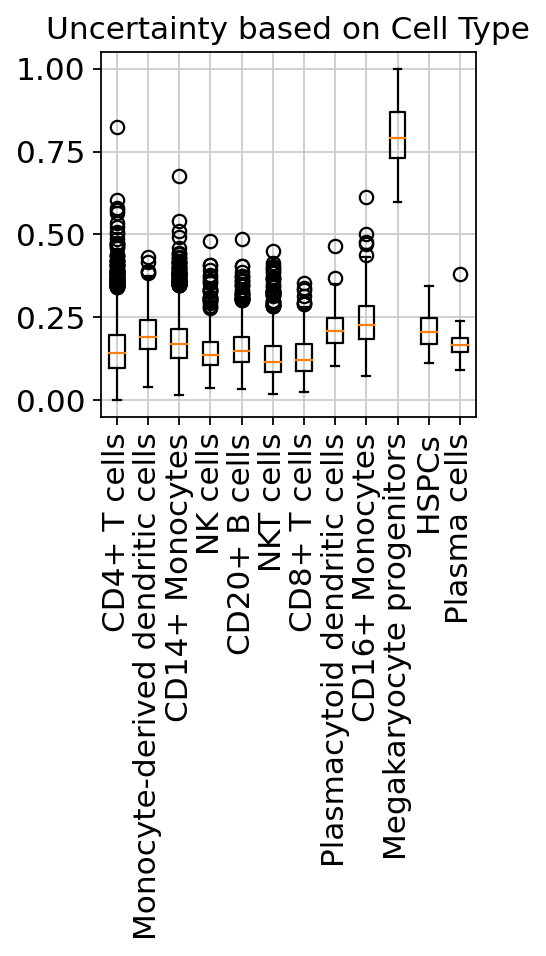

In [38]:
uncert_diagram(uncertainties, "cell_type")

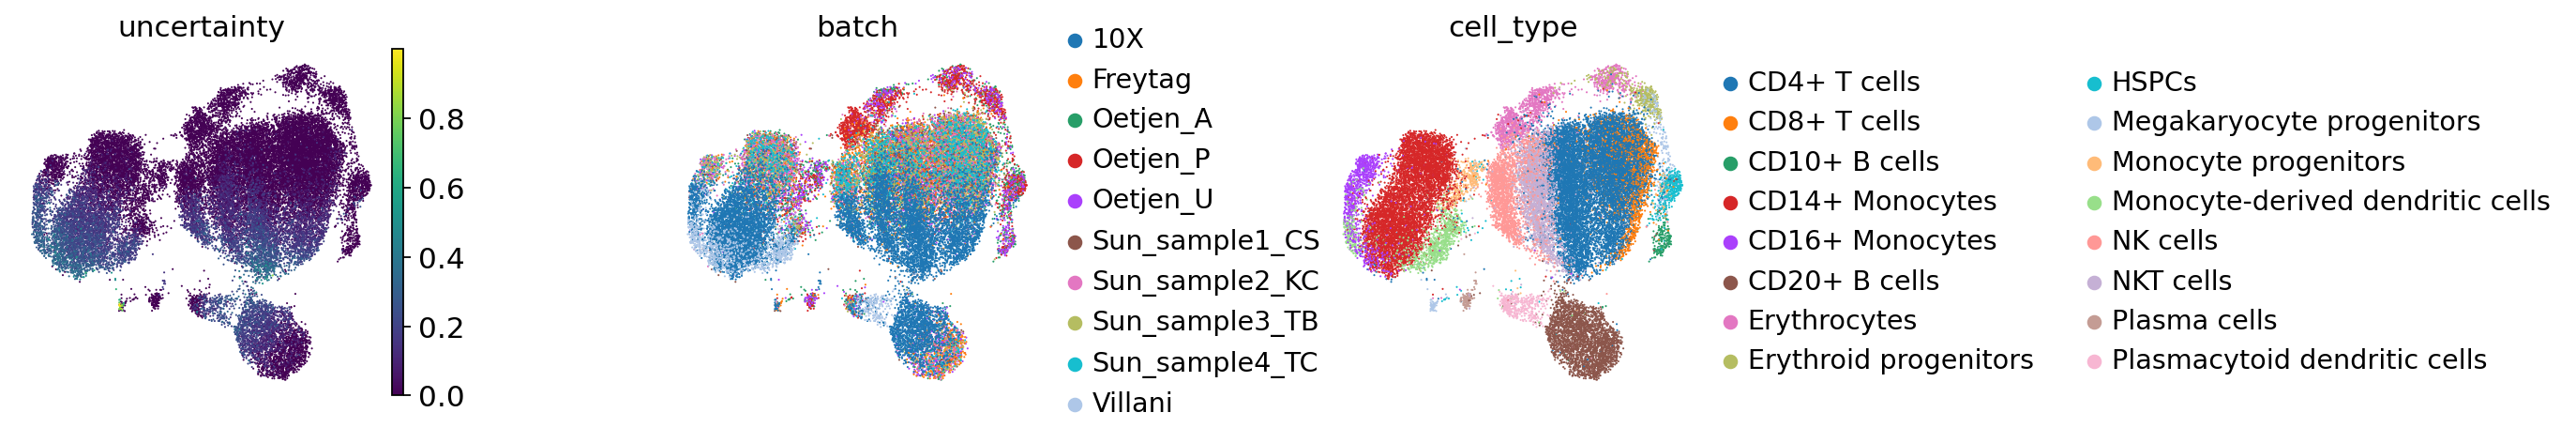

In [39]:
uncert_umap_diagram(
        adata_ref_latent,
        adata_query_latent,
        uncertainties["uncertainty"],
        batch_key = "batch",
        cell_type_key = "cell_type")